# Trabalho 3 - Disciplina: Deep Learning

Instituto de Computação - Unicamp 2021

Alunos:
* Daniele Montenegro da Silva Barros
* Rodrigo Dantas da Silva
* Thiago Bruschi Martins

Esse notebook serve como base para o desenvolvimento da Trabalho 3, e deve ser submetido após a conclusão das atividades propostas. 

Neste trabalho, iremos utilizar uma Rede Generativa Adversarial (GAN) para gerar dígitos de casas do *dataset* SVHN (*Street View House Numbers*). GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas). 

Abaixo, incluímos alguns imports, e mostramos uma maneira de processar o arquivo `train_32x32.mat` (pode ser baixado [aqui](http://ufldl.stanford.edu/housenumbers/train_32x32.mat)) que contém as imagens do dataset [SVHN](http://ufldl.stanford.edu/housenumbers/).

Sugerimos que o código da prática 8 seja estudado, e o mesmo **pode** servir de base para este trabalho, já que o procedimento de treino da GAN não muda.

## *Depois de cada atividade, inclua uma breve análise do que foi feito e dos resultados!*

# Imports

Vamos importar as dependências necessárias!

In [ ]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import sys
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carregue o dataset SVHN

Os dados são fornecidos em um arquivo .mat, que armazena um dicionário.

Para acessar os dados armazenados, utilizamos a função `loadmat` do pacote `scipy`.  Para acessar as imagens, acessamos o campo `['X']` desse dicionário. Um exemplo é mostrado abaixo:

Obs.: Lembre-se que para o Keras usando Tensorflow como backend, a dimensão dos canais deve ser a última do seu vetor.

(73257, 32, 32, 3)


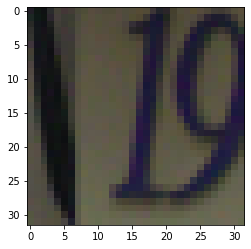

In [ ]:
# Load the dataset
X_train = loadmat('drive/My Drive/Dados/train_32x32.mat')['X']

X_train = np.moveaxis(X_train, -1, 0)
print(X_train.shape)

plt.imshow(X_train[0])


In [ ]:
X_train.shape

(73257, 32, 32, 3)

# Questão 1
(4,0) Adapte a arquitetura apresentada na Prática 8 para gerar imagens do SVHN. Explique as alterações realizadas, mostre alguns exemplos gerados e comente os resultados.

## Arquitetura
A rede mostrada na prática 8 gerava os dígitos do MNIST utilizando camadas densas. Apesar de também conter dígitos, o SVHN possui imagens maiores (32x32), e 3 canais (RGB). Essas diferenças fazem com que a rede precise ser levemente adaptada para poder trabalhar com o novo dataset e gerar novas amostras.

Portanto, altere o código da prática 8 para gerar dados do dataset SVHN com as camadas Densas da 'Vanilla' GAN, e mostre os resultados. A 'Vanilla' GAN conseguiu gerar as imagens do (mais complexo) dataset SVHN?


A rede do gerador é treinada ou preparada de forma que possa enganar a rede do discriminador criando as imagens reais de acordo com a entrada, e o discriminador é treinado para não ser enganado pela rede do gerador.

In [ ]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(256, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
  model.add(layers.Reshape(img_shape))

  #model.summary()

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  #model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Re-escale as imagens para [0, 1] para plotar.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

## Processo de Treinamento

In [ ]:
img_shape = (32, 32, 3)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_14 (Sequential)  (None, 1)                 1704961   
                                                                 
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_22 (Functional)       (None, 32, 32, 3)         3838720   
                                                                 
 model_21 (Functional)       (

## Pré-processamento

In [ ]:
#Definindo o tamanho do batch_size
batch_size=64

# Re-escale de -1 a 1
X_train = X_train / 127.5 - 1.

# Ground truth para treinamento. 
# Cria um conjunto de rótulos de saídas
# Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

## Rotina de Treinamento

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0 [D loss: 0.716119, acc.: 28.12%] [G loss: 0.595605]


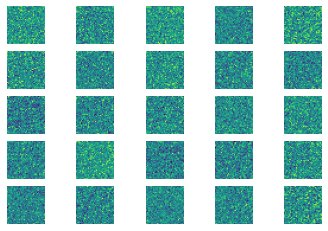

200 [D loss: 0.649631, acc.: 67.97%] [G loss: 1.579090]


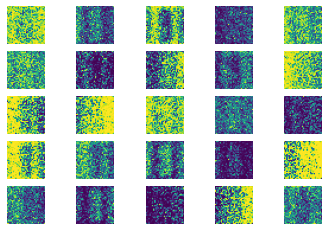

400 [D loss: 0.533855, acc.: 79.69%] [G loss: 1.712519]


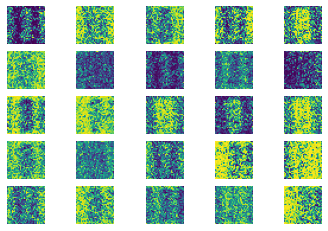

600 [D loss: 0.695711, acc.: 63.28%] [G loss: 2.135745]


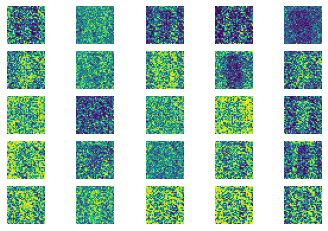

800 [D loss: 0.574136, acc.: 75.78%] [G loss: 1.191711]


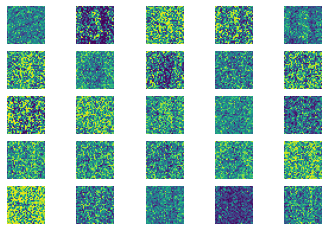

1000 [D loss: 0.627827, acc.: 61.72%] [G loss: 1.222295]


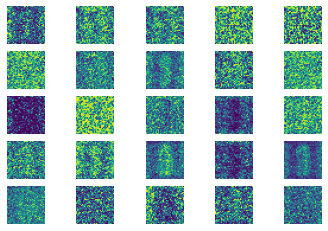

1200 [D loss: 0.567570, acc.: 73.44%] [G loss: 1.836203]


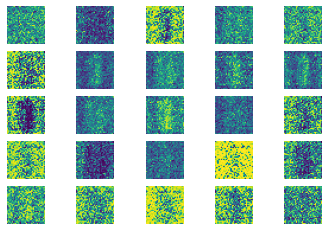

1400 [D loss: 0.431138, acc.: 83.59%] [G loss: 1.845472]


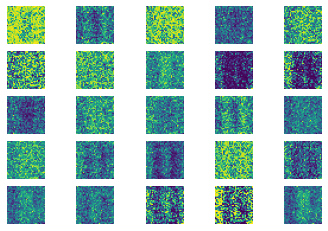

1600 [D loss: 0.494994, acc.: 77.34%] [G loss: 1.843996]


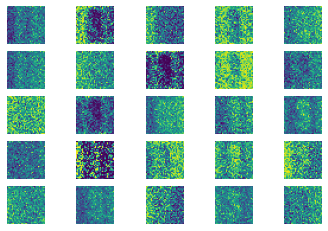

1800 [D loss: 0.706933, acc.: 57.81%] [G loss: 1.919485]


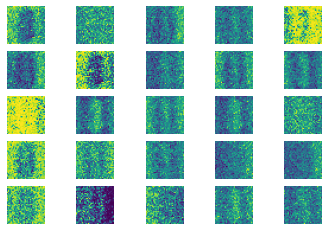

2000 [D loss: 0.511685, acc.: 71.09%] [G loss: 1.478150]


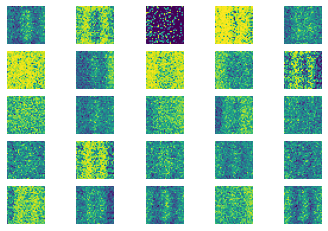

2200 [D loss: 0.543655, acc.: 68.75%] [G loss: 0.978104]


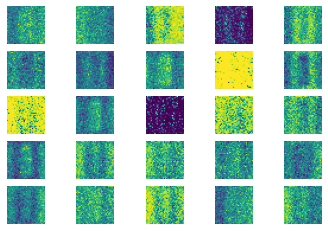

2400 [D loss: 0.600652, acc.: 62.50%] [G loss: 0.881623]


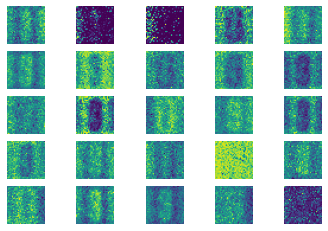

2600 [D loss: 0.611950, acc.: 64.84%] [G loss: 0.887159]


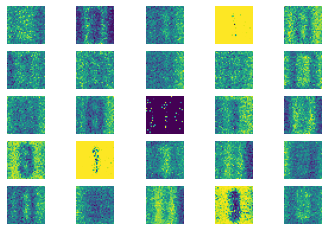

2800 [D loss: 0.658711, acc.: 56.25%] [G loss: 0.792956]


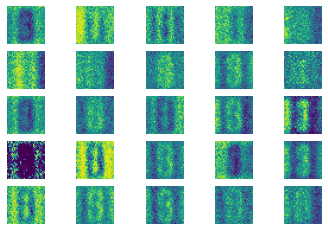

3000 [D loss: 0.618030, acc.: 71.88%] [G loss: 1.045048]


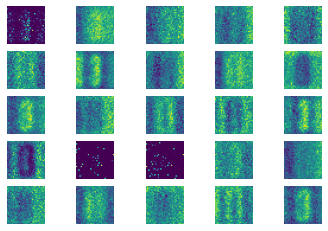

3200 [D loss: 0.560558, acc.: 74.22%] [G loss: 1.788278]


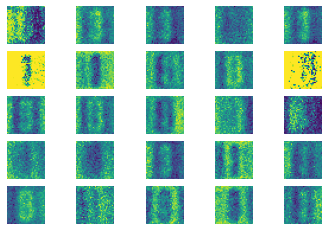

3400 [D loss: 0.592927, acc.: 65.62%] [G loss: 1.020686]


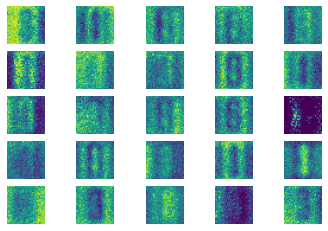

3600 [D loss: 0.497929, acc.: 73.44%] [G loss: 1.295194]


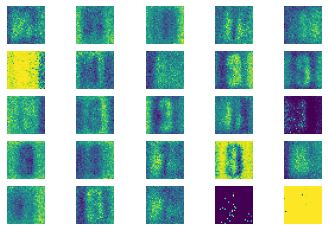

3800 [D loss: 0.543098, acc.: 71.09%] [G loss: 1.010535]


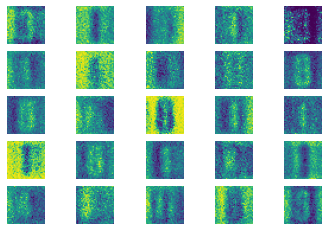

4000 [D loss: 0.534903, acc.: 73.44%] [G loss: 1.915227]


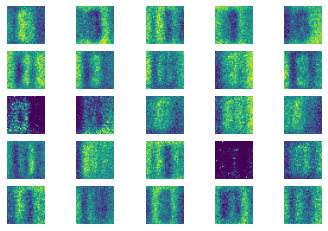

4200 [D loss: 0.595556, acc.: 69.53%] [G loss: 3.064732]


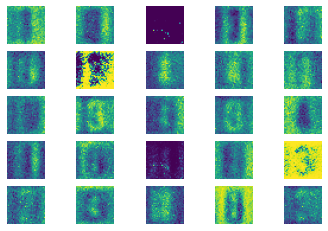

4400 [D loss: 0.491306, acc.: 76.56%] [G loss: 1.300327]


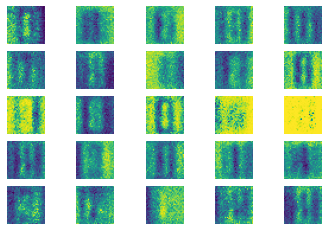

4600 [D loss: 0.487098, acc.: 73.44%] [G loss: 1.632860]


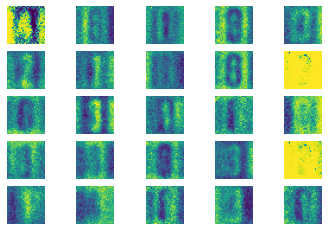

4800 [D loss: 0.562616, acc.: 71.88%] [G loss: 1.326907]


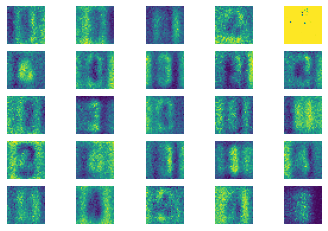

In [ ]:
iterations=5000
sample_interval=200

# Para rodar o código foi necessário chamar essa função
tf.config.run_functions_eagerly(True)

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

## Análise do Processamento

A única alteração realizada aqui foi sobre as dimensões das imagens (parâmetro img_shape). Dado que as imagens da Prática 8 eram imagens menores (28x28) e em escala de cinza, atualizamos as dimensões da imagem para 32x32x3, sendo a última dimensão correspondente ao espectro de cores, visto que neste laboratório utilizamos imagens coloridas.

Os exemplos de imagens geradas podem ser vistos na saída da célula anterior. Podemos observar a evolução do gerador ao longo das iterações, começando com imagens onde não existe padrão algum e terminando as 5000 iterações com imagens onde é possível identificar alguns números. No entanto, verificamos que nosso gerador se especializou em gerar certos números como o 3 e o 8, e às vezes aparecem o 2, o 4 e o 6. Isso aconteceu provavelmente pois o 3 e o 8 são bastante parecidos e isso torna mais fácil aprender estes números, pois provavelmente o gerador conseguiu enganar o discriminador mais vezes com estes números parecidos. o 6 também pode ser considerado parecido com o 8. Já o 2 e o 4 podem ser considerados mais distantes destes padrões, garantindo uma variedade maior para o nosso gerador.

Os resulatdos não alcançaram uma nitidez tão boa, mas provavelmente poderiam ser melhorados se aumentássemos o número de iterações. Uma análise mais profunda também poderia ser feita sobre o tipo do otimizador, batch_size e learning_rate. Devemos considerar também que a rede utilizada é bastante simples, e embora tenha consguido resultados mais nítidos no problema anterior (MNIST), o problema atual é consideravalmente mais complexo visto que são imagens coloridas, com mais de um dígito e capturadas do google street view, ou seja, possuem uma resolução bem menor do que as imagens de entrada da Prática 8.

# Questao 2
(4,0) Implemente a DCGAN (Deep Convolutional GAN), uma arquitetura melhor preparada para a geração de dados complexos. Ela está descrita no PDF. Mostre as imagens sintéticas geradas para o SVHN. Há alguma deficiência notada nas imagens geradas?

Defina aqui a arquitetura do gerador e discriminador da DCGAN seguindo o modelo segundo a imagem abaixo:

<img src='https://i.imgur.com/eU2XOxS.png' />




## Arquitetura

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.convolutional import UpSampling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU, Reshape, Conv2DTranspose, ReLU, Input
from keras.layers.core import Flatten
from tensorflow.keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

def discriminator_model_gam(img_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    
    return Model(img, validity)


def generator_model_gam(latent_dim):
  n_nodes = 128 * 8 * 8
  model = Sequential()

  model.add(Dense(n_nodes, activation='relu', input_dim=latent_dim))
  model.add(Reshape((8, 8, 128)))

  model.add(UpSampling2D())
  model.add(layers.Conv2D(128, 3, strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())

  model.add(UpSampling2D())
  model.add(layers.Conv2D(64, 3, strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())

  model.add(layers.Conv2D(3, 3, strides=(1,1), padding='same'))
  model.add(layers.Activation('tanh'))
  
  noise = Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

## Processo de Treinamento

In [ ]:
img_shape = (32, 32, 3)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator_DCGAN = discriminator_model_gam(img_shape)
discriminator_DCGAN.summary()
discriminator_DCGAN.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Constrói o gerador
generator_DCGAN = generator_model_gam(latent_dim)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator_DCGAN(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator_DCGAN.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator_DCGAN(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined_DCGAN = Model(z, validity)
combined_DCGAN.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined_DCGAN.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 389441    
                                                                 
Total params: 389,441
Trainable params: 389,441
Non-trainable params: 0
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_4 (Functional)        (None, 32, 32, 3)         1051267   
                                                                 
 model_3 (Functional)        (None, 

## Pré-processamento

In [ ]:
batch_size=64

# Re-escale de -1 a 1
X_train = X_train / 127.5 - 1.

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

## Rotina de Treinamento

Dica: Estude o código mostrado em sala na prática 8, e adapte-o para treinar a DCGAN.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0 [D loss: 0.647186, acc.: 62.50%] [G loss: 0.814021]


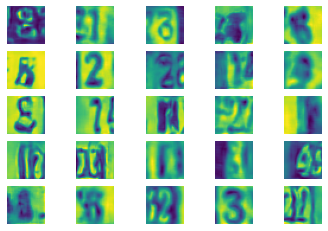

1000 [D loss: 0.635445, acc.: 65.62%] [G loss: 0.895959]


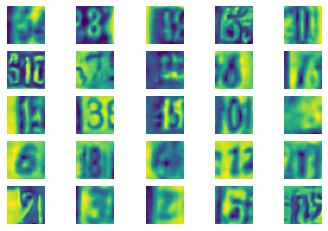

2000 [D loss: 0.648771, acc.: 59.38%] [G loss: 0.786122]


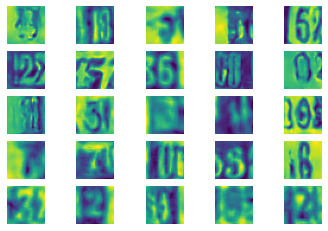

3000 [D loss: 0.652215, acc.: 60.94%] [G loss: 0.786159]


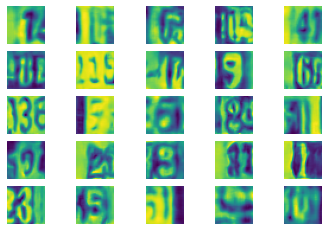

4000 [D loss: 0.686977, acc.: 58.59%] [G loss: 0.841622]


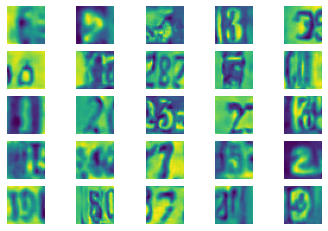

5000 [D loss: 0.627186, acc.: 65.62%] [G loss: 0.810971]


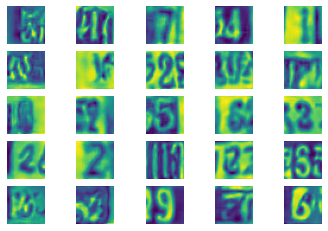

6000 [D loss: 0.645131, acc.: 65.62%] [G loss: 0.847954]


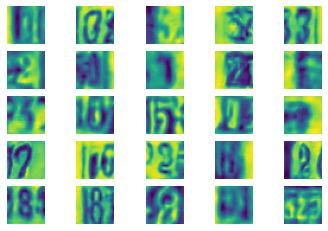

7000 [D loss: 0.660991, acc.: 61.72%] [G loss: 0.831223]


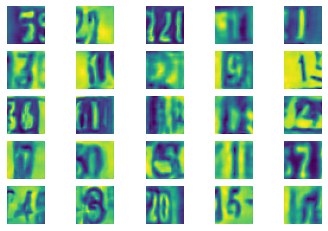

8000 [D loss: 0.692962, acc.: 60.16%] [G loss: 0.847170]


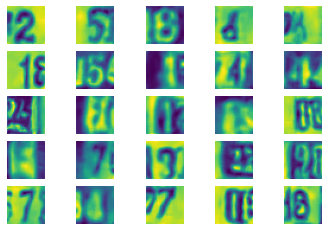

9000 [D loss: 0.634936, acc.: 62.50%] [G loss: 0.874075]


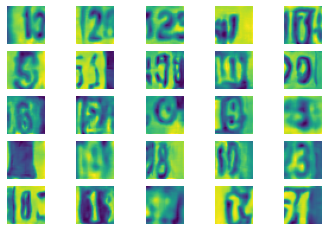

In [ ]:
iterations=10000
sample_interval=1000

# Para rodar o código foi necessário chamar essa função
tf.config.run_functions_eagerly(True)

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator_DCGAN.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator_DCGAN.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator_DCGAN.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined_DCGAN.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator_DCGAN)

## Análise do Processamento

Os resultados foram muito melhores. Agora as imagens estão muito mais nítidas do que na rede anterior. Na rede anterior as imagens apresentavam uma nitidez muito baixa, todos os números pareciam ofuscados ou embaçados. Além disso, agora é possível verificar números com mais de um dígito na mesma imagem, o que parece ser um grande avanço em relação a rede anterior, visto que a grande maioria dos (pra não dizer todos) números de casa possuem mais de um dígito. Podemos observar ainda que aparentemente houve uma variabilidade maior dos dígitos em relação ao resultado da primeira rede, pois agora podemos observar com clareza os dígitos 1, 2, 3, 5, 6, 7, 8 e 9. Ou seja, o dígito que menos aparece é o 4, provavelmente nossa rede teve maior dificuldade em gerá-lo pois ele não é parecido com nenhum outro dígito. Mas não podemos afirmar isso com tanta certeza pois seria necessário um estudo mais aprofundado dos resultados

# Questão 3
(2,0) Compare e interprete os resultados e elabore uma conclusão discutindo os experimentos.



Observamos que a primeira rede possui muito mais parâmetros treináveis do que a segunda, são quase 4 milhões contra cerca de 1 milhão de parâmetros da segunda rede. No entanto, essa diferença não foi refletida nos resultados. As imagens geradas pela segunda rede foram muito melhores: apresentaram uma nitidez bem maior dos dígitos, números com mais dígitos e ainda uma maior variabilidade dos dígitos gerados. Embora a segunda rede tenha sido treinada com o dobro de iterações que a primeira (10 mil contra 5 mil), mesmo na metade do processo (ou seja, com 5 mil iterações) os resultados já eram melhores do que a primeira. Provavelmente essa diferença entre os resultados se dá pela melhoria apresentada pelas redes convolucionais em relação as redes de camada densa, que graças aos filtros (kernels) conseguem processar as imagens através de pequenas regiões (áreas ou volumes) ao invés de tratá-las como vetores unidimensionais que é o que as redes densas fazem. Comparando as duas redes, essa é a principal diferença, além das camadas de UpSampling na DCGAN que geram uma certa aumentação dos dados.